In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import *
from utils.manifold_utils import *

from flow_matching.utils.manifolds import Manifold, Sphere, Euclidean
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import SoftDTW
import os
from tqdm import tqdm
from typing import Dict, Any

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
torch.manual_seed(3420934659826)

In [3]:
run_parameters =  yaml.safe_load(Path("./configs/sphere_euclidean.yaml").read_text())
run_parameters

{'train': {'lr': 0.0001,
  'epochs': 100001,
  'batch_size': 100,
  'inf_every': 4000,
  'print_every': 4000,
  'device': 'cpu',
  'inf_runs_num': 1,
  'inf_run_step': 0.05},
 'model': {'hidden_dim': 96, 'num_layers': 6, 'embed_dim': 24},
 'data': {'dim': 3,
  'manifold': 'Sphere',
  'datasets': ['Sine'],
  'horizon_size': 20,
  'inference_horizon': 10,
  'scale_factor': 2.0,
  'downsample': 5,
  'sample_points': 300,
  'mean': 0.0,
  'std': 0.5},
 'ema': {'warmup': 2000, 'update': 5, 'decay': 0.999},
 'scheduler': {'step': 10000, 'gamma': 0.5}}

In [4]:
manifold_types = {'None' : None, 'Euclidean': Euclidean(), 'Sphere':Sphere()}
train_sets= list(range(6)) #+ list(range(7, 13)) + list(range(14, 20)) + list(range(21, 27))
val_sets = [6]#, 13, 20, 27]
print(train_sets, val_sets)

[0, 1, 2, 3, 4, 5] [6]


In [5]:
manifold = manifold_types[run_parameters['data']['manifold']]
LASA_datasets = run_parameters['data']['datasets']

dataset = StatePyLASADataset(LASA_datasets,
                               train=train_sets,
                               horizon_size=run_parameters['data']['horizon_size'],
                               scaling_factor=run_parameters['data']['scale_factor'],
                               downsample = run_parameters['data']['downsample'],
                               manifold=manifold,
                               dim_to=run_parameters['data']['dim'])

print(dataset.__len__())

train_dataset = torch.utils.data.Subset(dataset, train_sets)

test_dataset = torch.utils.data.Subset(dataset, val_sets)

train_dataloader = DataLoader(train_dataset,
                       batch_size=run_parameters['train']['batch_size'],
                       shuffle=True)

val_dataloader = DataLoader(test_dataset,
                    batch_size=run_parameters['train']['batch_size'],
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _, label = next(iter(test_dataloader))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=4,
                    shuffle=False)

print(test_dataset.__len__())
print(train_dataset.__len__())

gt_obs, gt_horizon, label = next(iter(gt_test))
print(gt_obs.shape)

7
1
6
torch.Size([1, 200, 7])


In [6]:
def save_config_to_yaml(config: Dict[str, Any], filepath: str) -> None:
    try:
        with open(filepath, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)  
    except Exception as e:
        raise IOError(f"Failed to save config to {filepath}") from e

In [7]:
vf = StateMLP(
    action_dim=run_parameters['data']['dim'],
    hidden_dim=run_parameters['model']['hidden_dim'],
    horizon_size=run_parameters['data']['horizon_size'],
    num_layers=run_parameters['model']['num_layers'],
    label_embedding_dim=run_parameters['model']['embed_dim'],
    num_classes=len(LASA_datasets)
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema']['decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable params number:", params)

Learnable params number: 84304


In [10]:
import torch
import matplotlib.pyplot as plt
import time

def run_train(vf, train_dataloader, 
              val_dataloader, 
              run_parameters, 
              manifold, 
              ema_vf, dataset, 
              gt_obs, 
              run_name, run_path="./runs"):
    save_path = os.path.join(run_path, run_name)
    os.makedirs(save_path, exist_ok=True)
    save_config_to_yaml(run_parameters, os.path.join(save_path, 'config.yaml'))
    
    device = run_parameters['train']['device']
    vf.to(device)

    optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['train']['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                               step_size=run_parameters['scheduler']['step'], 
                                               gamma=run_parameters['scheduler']['gamma'])

    path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=Euclidean())

    train_losses = []
    val_losses = []
    lrs = []
    best_val_loss = float('inf')

    start_time = time.time()
    for i in range(run_parameters['train']['epochs']):
        for batch in train_dataloader:
            optim.zero_grad()

            train_loss = step_euc_sphere(vf=vf, 
                                        batch=batch, 
                                        run_parameters=run_parameters, 
                                        path=path, 
                                        device=device)
            
            train_loss.backward()
            optim.step()

            if i > run_parameters['ema']['warmup'] and i % run_parameters['ema']['update'] == 0: 
                ema_vf.update()

            if i % run_parameters['train']['print_every'] == 0:
                elapsed = time.time() - start_time
                print('| iter {:6d} | {:5.2f} sec | train loss {:8.3f} '
                      .format(i, elapsed, train_loss.item()))
                
                plt.figure()
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(os.path.join(save_path,'loss_plot.png'))
                plt.close()

                plt.figure()
                plt.plot(lrs, label='Learning rate')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('lr')
                plt.legend()
                plt.savefig(os.path.join(save_path,'lr_plot.png'))
                plt.close()
                
                with torch.no_grad():
                    ema_vf.store()
                    ema_vf.copy_to()
                    val_batch = next(iter(val_dataloader))
                    loss_val = step_euc_sphere(vf=vf, 
                                                batch=val_batch, 
                                                run_parameters=run_parameters, 
                                                path=path, 
                                                device=device)
                    train_losses.append(train_loss.item())
                    val_losses.append(loss_val.item())
                    if loss_val.item() < best_val_loss:
                        best_val_loss = loss_val.item()
                        torch.save(vf.state_dict(), os.path.join(save_path, 'best_model.pth'))
                    print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val.item()))

                    infered = run_inference(manifold=Euclidean(),
                                model=vf,
                                run_parameters=run_parameters,
                                class_labels=dataset.get_label_maping(),
                                gt_obs=gt_obs,
                                inference_type="Euclidean sphere")
                    for label_name in infered.keys():
                        print(len(infered[label_name]['results']))
                        plot_3d_points_interactive(infered[label_name]['results'])
                    ema_vf.restore()
                start_time = time.time()
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
        


    vf.load_state_dict(torch.load(os.path.join(save_path,'best_model.pth'), weights_only=True))
    # with torch.no_grad():
    #     infered = run_inference(manifold=manifold,
    #                             model=vf,
    #                             run_parameters=run_parameters,
    #                             class_labels=dataset.get_label_maping(),
    #                             gt_obs=gt_obs)
    #     for label_name in infered.keys():
    #         plot_flow_on_sphere(infered[label_name]['results'], 
    #                             infered[label_name]['samples'], 
    #                             gt_obs[dataset.get_label_maping()[label_name]],
    #                             label=label_name)
    #         plt.savefig(os.path.join(save_path, f'best_model_flow_{label_name}.png'))
    #         plt.close()

In [11]:
run_train(vf=vf, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            run_parameters=run_parameters, 
            manifold=manifold, 
            ema_vf=ema_vf, dataset=dataset, 
            gt_obs=gt_obs, 
            run_name="Sphere Euclidean 3D")

| iter      0 |  0.01 sec | train loss    0.204 
| iter      0 | validation loss:    0.176 


1


Output()

| iter   4000 | 40.46 sec | train loss    0.013 
| iter   4000 | validation loss:    0.021 


1


Output()

| iter   8000 | 36.55 sec | train loss    0.009 
| iter   8000 | validation loss:    0.006 


1


Output()

| iter  12000 | 36.50 sec | train loss    0.008 
| iter  12000 | validation loss:    0.010 


1


Output()

| iter  16000 | 35.91 sec | train loss    0.010 
| iter  16000 | validation loss:    0.008 


1


Output()

| iter  20000 | 35.73 sec | train loss    0.005 
| iter  20000 | validation loss:    0.007 


1


Output()

| iter  24000 | 37.25 sec | train loss    0.005 
| iter  24000 | validation loss:    0.005 


1


Output()

| iter  28000 | 36.39 sec | train loss    0.004 
| iter  28000 | validation loss:    0.008 


1


Output()

KeyboardInterrupt: 

In [11]:
criterion =  SoftDTW(gamma=1.0, normalize=True)

In [12]:
class_labels = dataset.get_label_maping()
for label_name in list(class_labels.keys()):
    results = []
    samples = []
    errors = []
    for _ in range(100): #run_parameters['train']['inf_runs_num']):
        label = torch.tensor(class_labels[label_name],dtype=torch.long).unsqueeze(0)
        res, samp, paths = infer_model(model=vf, 
                        start=gt_obs[class_labels[label_name],0,:run_parameters['data']['dim']], 
                        manifold=manifold,
                        label=label,
                        dim_manifold=run_parameters['data']['dim'],
                        model_horizon= run_parameters['data']['horizon_size'],
                        inference_horizon= 20,#run_parameters['data']['inference_horizon'],
                        sample_points=run_parameters['data']['sample_points'],
                        mean=run_parameters['data']['mean'],
                        std=run_parameters['data']['std'],
                        step_size=0.1,
                        return_intermediates=True)
        results.append(res)
        samples.append(samp)
        for sample in tqdm(range(len(paths)), desc="Path error", leave=False):
            path = paths[sample]
            for i in range(path.shape[2]):
                real_geodesic = sample_uniform_geodesic_path(manifold=manifold, 
                                                            start=path[0,0,i,:], #[1/step, b, horizon, dim]
                                                            finish=path[-1,0,i,:],
                                                            num_points=path.shape[0])
                errors.append(curve_geodesic_MSE(manifold=manifold, 
                                                x_curve=real_geodesic, 
                                                y_curve=path[:,0,i,:]))
        
    # plot_flow_on_sphere(results, samples, gt_obs[class_labels[label_name]], label=label_name, dynamic=True)
    print(np.array(errors).mean())

0.00026770022224637923


In [15]:
def geodesic_distance(p, q):
    dot = torch.clamp(torch.sum(p * q, dim=-1), -1.0, 1.0)
    return torch.arccos(dot)

def trajectory_geodesic_stats(trajectories):
    N = len(trajectories)
    num_points, dim = trajectories[0].shape

    traj_tensor = torch.stack(trajectories, dim=0)

    means = []
    variances = []

    for t in range(num_points):
        points_t = traj_tensor[:, t, :]
        mean_vec = points_t.mean(dim=0)
        mean_vec = mean_vec / mean_vec.norm()
        means.append(mean_vec)

        dists = geodesic_distance(points_t, mean_vec)
        variances.append((dists ** 2).mean())

    return torch.stack(means), torch.stack(variances)

In [16]:
mean, std = trajectory_geodesic_stats(results)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_geodesic_stats_on_sphere(means, variances, label, elev=-90, azim=0):
    if isinstance(means, torch.Tensor):
        means = means.cpu().numpy()
    if isinstance(variances, torch.Tensor):
        variances = variances.cpu().numpy()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.2)

    p = ax.scatter(means[:, 0], means[:, 1], means[:, 2],
                   c=variances, cmap='plasma', s=40, label="Geodesic Mean")

    cb = plt.colorbar(p, ax=ax, shrink=0.7)
    cb.set_label("Variance")

    ax.view_init(elev=elev, azim=azim)
    ax.set_title(label + " var of trajectory")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.tight_layout()
    plt.show()


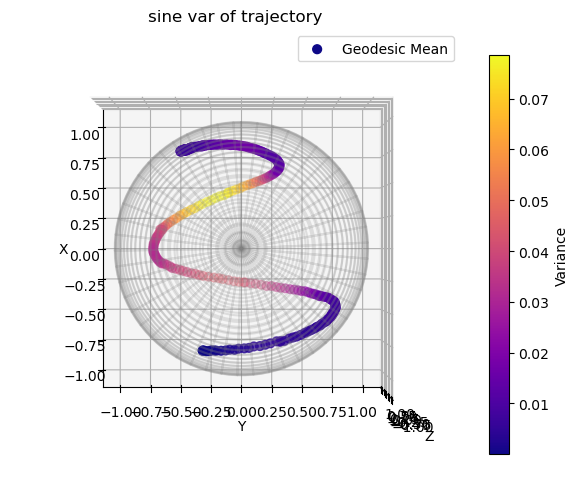

In [18]:
plot_geodesic_stats_on_sphere(mean, std, label="sine")